In [1]:
!pip install https://github.com/IBM/causallib/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 7.7 MB 3.6 MB/s
  Created wheel for causallib: filename=causallib-0.8.2-py3-none-any.whl size=2098051 sha256=65328939813e0de38a112c7cfe80d22a67620d9b41c89fafd32b61bcab2ffe88
  Stored in directory: /tmp/pip-ephem-wheel-cache-ka8o172f/wheels/08/02/94/583a8b9c10f7fa0b75ff840c41b43b3a3aa3a8fb7057ed60a3
Successfully built causallib


In [13]:
import numpy as np

In [32]:
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression,LinearRegression
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/content/drive/MyDrive/HR_CausalAnalytics/HR.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [8]:
#Drop unuseful columns--employee count, employee number, daily rate,dtandard hours, stockoption level

unused = ['DailyRate','EmployeeCount','EmployeeNumber','HourlyRate','OverTime','StockOptionLevel','WorkLifeBalance']

In [9]:
df = data.drop(unused,axis=1)

In [10]:
df.describe()

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,9.192517,2.912925,2.721769,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,11.279592,2.799320,7.008163,4.229252,2.187755,4.123129
std,9.135373,8.106864,1.024165,1.093082,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,7.780782,1.289271,6.126525,3.623137,3.222430,3.568136
min,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,6.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,7.000000,3.000000,3.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,10.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,14.000000,4.000000,4.000000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,15.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,29.000000,5.000000,4.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,40.000000,6.000000,40.000000,18.000000,15.000000,17.000000


In [11]:
#Recode some Variables

df['Education'] = df['Education'].map({1:'Below College',
                                       2:'College',
                                       3:'Bachelor',
                                       4:'Master',
                                       5:'Doctor'})

In [12]:
df['Education'].value_counts()

Bachelor         572
Master           398
College          282
Below College    170
Doctor            48
Name: Education, dtype: int64

In [23]:
#Dichotomize number of years since last promotion

df['Promotions'] = np.where(df['YearsSinceLastPromotion']>0,1,0)

In [25]:
df['Promotions'].value_counts()

1    889
0    581
Name: Promotions, dtype: int64

In [26]:
df['Performance']=df['Attrition']

In [27]:
df['Performance'].value_counts()

No     1233
Yes     237
Name: Performance, dtype: int64

In [28]:
df['Performance'] =df['Performance'].map({'No':0,'Yes':1})

In [29]:
# bin years of working experience

def total(exper):
  if exper < 6:
    return '0-5yrs'
  elif exper < 11:
    return '6-10yrs'
  elif exper < 16:
    return '11-15yrs'
  else:
    return '>15yrs'

In [30]:
df['work_exp'] = df['TotalWorkingYears'].apply(total)

In [31]:
df['work_exp'].value_counts()

6-10yrs     607
>15yrs      356
0-5yrs      316
11-15yrs    191
Name: work_exp, dtype: int64

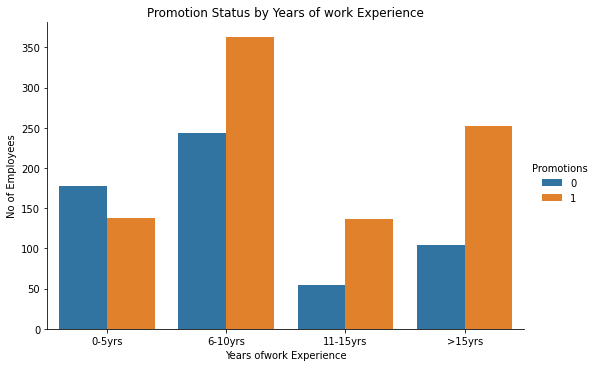

In [33]:
sns.catplot(x='work_exp',kind="count",hue="Promotions",height=5,aspect=1.5,data=df,order=['0-5yrs','6-10yrs','11-15yrs','>15yrs'])
plt.xlabel("Years ofwork Experience")
plt.ylabel("No of Employees")
plt.title("Promotion Status by Years of work Experience");

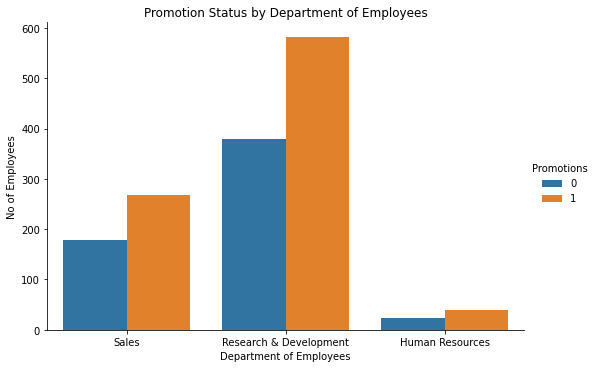

In [34]:
sns.catplot(x='Department',kind="count",hue="Promotions",height=5,aspect=1.5,data=df)
plt.xlabel("Department of Employees")
plt.ylabel("No of Employees")
plt.title("Promotion Status by Department of Employees");

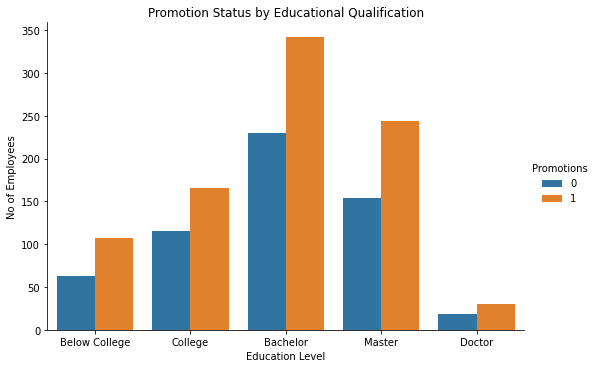

In [35]:
sns.catplot(x='Education',kind="count",hue="Promotions",height=5,aspect=1.5,data=df,order=['Below College','College','Bachelor','Master','Doctor'])
plt.xlabel("Education Level")
plt.ylabel("No of Employees")
plt.title("Promotion Status by Educational Qualification");

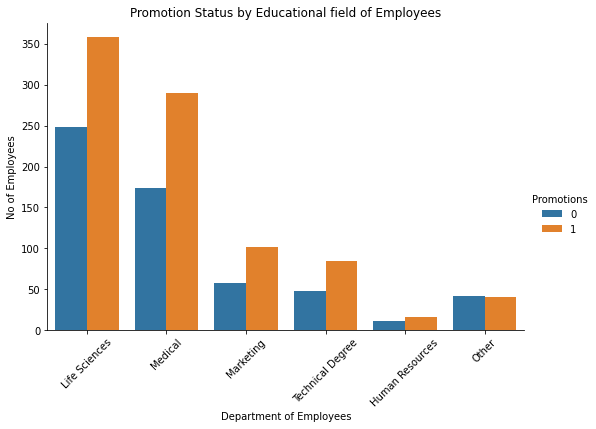

In [36]:
sns.catplot(x='EducationField',kind="count",hue="Promotions",height=5,aspect=1.5,data=df,order=['Life Sciences','Medical','Marketing','Technical Degree','Human Resources','Other'])
plt.xlabel("Department of Employees")
plt.ylabel("No of Employees")
plt.xticks(rotation=45)
plt.title("Promotion Status by Educational field of Employees");

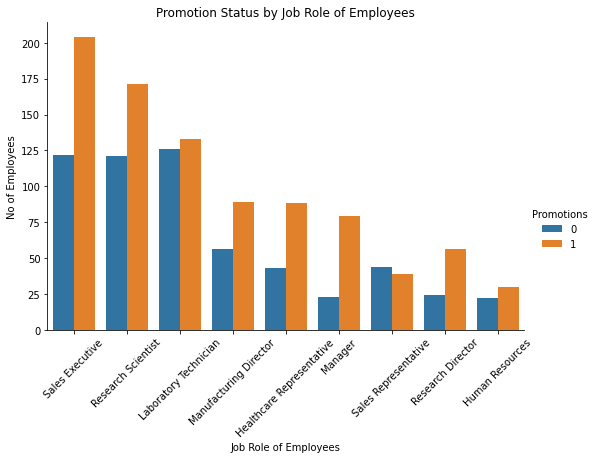

In [37]:
sns.catplot(x='JobRole',kind="count",hue="Promotions",height=5,aspect=1.5,data=df)
plt.xlabel("Job Role of Employees")
plt.ylabel("No of Employees")
plt.xticks(rotation=45)
plt.title("Promotion Status by Job Role of Employees");

## Data Preparation for Causal Analysis

In [38]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Promotion',
       'Promotions', 'Performance', 'work_exp'],
      dtype='object')

In [39]:
confounders = ['Age','Department','Education','Gender','MaritalStatus','YearsAtCompany','JobRole','EducationField']

In [40]:
X = df[confounders]

In [41]:
X = pd.get_dummies(X,prefix_sep='=',drop_first=True)

In [42]:
X.shape

(1470, 24)

In [43]:
a = df['Promotions']

In [44]:
y = df['Performance']

In [45]:
y.value_counts()

0    1233
1     237
Name: Performance, dtype: int64

In [46]:
a.value_counts()

1    889
0    581
Name: Promotions, dtype: int64

##Check the covariate balance

In [47]:
from causallib.evaluation.metrics import calculate_covariate_balance
calculate_covariate_balance(X,a,w=a*0+1)["unweighted"].sort_values()

covariate
Department=Research & Development    0.003484
Department=Sales                     0.007542
JobRole=Manufacturing Director       0.008854
Education=Doctor                     0.011048
Education=Master                     0.014985
JobRole=Human Resources              0.015680
Gender=Male                          0.018086
Education=College                    0.023160
Education=Below College              0.026499
JobRole=Research Scientist           0.028116
EducationField=Technical Degree      0.029556
EducationField=Marketing             0.031573
JobRole=Sales Executive              0.033290
EducationField=Life Sciences         0.034672
MaritalStatus=Single                 0.039789
EducationField=Medical               0.040776
MaritalStatus=Married                0.068793
JobRole=Research Director            0.069047
EducationField=Other                 0.082284
JobRole=Sales Representative         0.095231
JobRole=Laboratory Technician        0.123408
JobRole=Manager         

In [48]:
X.groupby(a).mean()

,Age,YearsAtCompany,Department=Research & Development,Department=Sales,Education=Below College,Education=College,Education=Doctor,Education=Master,Gender=Male,MaritalStatus=Married,MaritalStatus=Single,JobRole=Human Resources,JobRole=Laboratory Technician,JobRole=Manager,JobRole=Manufacturing Director,JobRole=Research Director,JobRole=Research Scientist,JobRole=Sales Executive,JobRole=Sales Representative,EducationField=Life Sciences,EducationField=Marketing,EducationField=Medical,EducationField=Other,EducationField=Technical Degree
Promotions,,,,,,,,,,,,,,,,,,,,,,,,
0,35.641997,4.401033,0.652324,0.306368,0.108434,0.199656,0.030981,0.265060,0.607573,0.428571,0.335628,0.037866,0.216867,0.039587,0.096386,0.041308,0.208262,0.209983,0.075731,0.42685,0.099828,0.299484,0.072289,0.082616
1,37.761530,8.712036,0.654668,0.301462,0.120360,0.186727,0.033746,0.274466,0.595051,0.476940,0.309336,0.033746,0.149606,0.088864,0.100112,0.062992,0.192351,0.229471,0.043870,0.40270,0.113611,0.326209,0.044994,0.094488


There some variations in distribution of the control and treatments.  We shall first estimate our model without balancing the covariates, then we will then correct for the imbalance and run the model again.

In [49]:
from causallib.estimation import (PropensityFeatureStandardization,
                                  WeightedStandardization,
                                  AIPW,
                                  MarginalOutcomeEstimator,
                                  IPW,
                                  Standardization,
                                  StratifiedStandardization,
                                  Matching,
                                  PropensityMatching)

In [50]:
from causallib.preprocessing.transformers import MatchingTransformer


def learner(): return LogisticRegression(
    solver="liblinear", class_weight="balanced", max_iter=5000)


def makeipw(): return IPW(learner=learner())
def makestd(): return StratifiedStandardization(learner=LinearRegression())


all_estimators = [
    MarginalOutcomeEstimator(learner=LinearRegression()),
    Matching(with_replacement=False),
    PropensityMatching(learner=learner(), caliper=0.1),
    IPW(learner=learner()),
    Standardization(learner=LinearRegression()),
    StratifiedStandardization(learner=LinearRegression()),
    PropensityFeatureStandardization(makestd(), makeipw()),
    WeightedStandardization(makestd(), makeipw()),
    AIPW(makestd(), makeipw()),
]


def get_all_estimates(X, a, y):
    estimates = {}
    for estimator in all_estimators:
        estimator.fit(X, a, y)
        estimator_name = estimator.__class__.__name__
        estimates[estimator_name] = estimator.estimate_population_outcome(
            X, a, y)
    estimates_df = pd.concat(estimates, axis=1).T
    return estimates_df

In [51]:
all_estimates = get_all_estimates(X, a, y)
all_estimates.assign(ATE=all_estimates[1] - all_estimates[0])

,0,1,ATE
MarginalOutcomeEstimator,0.189329,0.142857,-0.046472
Matching,0.189329,0.154905,-0.034423
PropensityMatching,0.137415,0.156463,0.019048
IPW,0.132221,0.157974,0.025752
Standardization,0.168711,0.156332,-0.012379
StratifiedStandardization,0.123757,0.148979,0.025222
PropensityFeatureStandardization,0.106254,0.145197,0.038943
WeightedStandardization,0.145233,0.155599,0.010367
AIPW,0.171247,0.157579,-0.013668


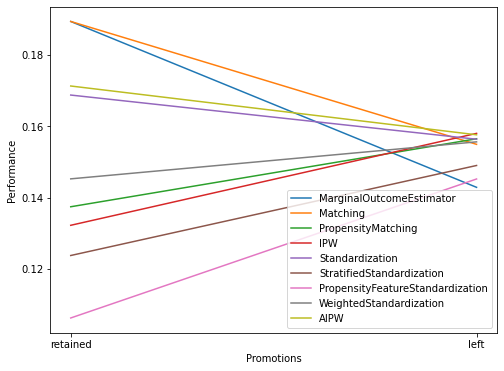

In [52]:
f, ax = plt.subplots(figsize=(8, 6))
all_estimates.T.plot(ax=ax)
ax.set_ylabel(y.name)
ax.set_xlabel(a.name)
plt.xticks([0, 1], ["retained", "left"]);

##Correcting for imbalances

In [54]:
# Weighting method
from causallib.estimation import IPW

lr = LogisticRegression(solver='lbfgs',max_iter=1000)
ipw = IPW(lr)

In [55]:
#fit the model

ipw.fit(X,a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=1000))

In [56]:
outcomes = ipw.estimate_population_outcome(X,a,y)
outcomes

0    0.118844
1    0.155134
dtype: float64

In [57]:
all_estimates_balanced = get_all_estimates(X,a,y)
all_estimates_balanced.assign(ATE=all_estimates_balanced[1]-all_estimates_balanced[0])

,0,1,ATE
MarginalOutcomeEstimator,0.189329,0.142857,-0.046472
Matching,0.189329,0.154905,-0.034423
PropensityMatching,0.137415,0.156463,0.019048
IPW,0.132221,0.157974,0.025752
Standardization,0.168711,0.156332,-0.012379
StratifiedStandardization,0.123757,0.148979,0.025222
PropensityFeatureStandardization,0.106254,0.145197,0.038943
WeightedStandardization,0.145233,0.155599,0.010367
AIPW,0.171247,0.157579,-0.013668


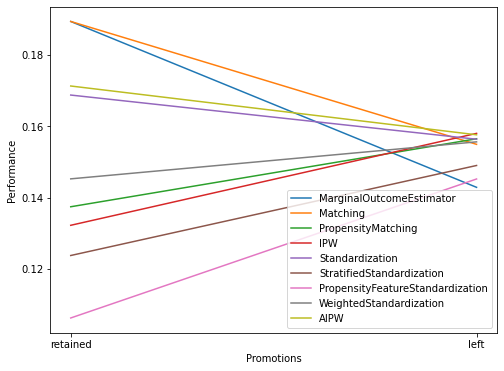

In [59]:
f, ax = plt.subplots(figsize=(8, 6))
all_estimates_balanced.T.plot(ax=ax)
plt.ylabel(y.name)
plt.xlabel(a.name)
plt.xticks([0, 1], ["retained", "left"]);